# Enabling and testing the GPU
First, you'll need to enable GPUs for the notebook:

Navigate to Edit→Notebook Settings
select GPU from the Hardware Accelerator drop-down

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
from psutil import virtual_memory
virtual_memory().total / 1e9

13.653557248

In [3]:
!git clone https://github.com/lukewood/sota-dqn && cd sota-dqn && pip install .

Cloning into 'sota-dqn'...
remote: Enumerating objects: 345, done.
remote: Counting objects: 100% (345/345), done.
remote: Compressing objects: 100% (237/237), done.
remote: Total 345 (delta 163), reused 245 (delta 82), pack-reused 0
Receiving objects: 100% (345/345), 1.85 MiB | 6.25 MiB/s, done.
Resolving deltas: 100% (163/163), done.
Processing /content/sota-dqn
  Created wheel for sota-dqn: filename=sota_dqn-0.0.7-cp36-none-any.whl size=7140 sha256=a516cdd2c33ec7d455f72eb9a72d41da6d976249c83f5f755b16e9b814b6848e
  Stored in directory: /root/.cache/pip/wheels/cc/3b/80/e906e6bc3272a50c87a131d2480e9c22714cec0a49708ec716
Successfully built sota-dqn


In [4]:
!pip show sota_dqn

Name: sota-dqn
Version: 0.0.7
Summary: State of the art opinionanted DQN training and inference
Home-page: https://github.com/lukewood/sota-dqn
Author: Luke Wood
Author-email: lukewoodcs@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: 
Required-by: 


In [5]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install gym[atari]
!pip install rich

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (493 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 144487 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The 

In [51]:
%matplotlib inline
from rich.table import Table
from rich.console import Console
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

persistence_file="gs://sota-dqn-ms-pacman"

mpl.use('Agg')
episodes = Table(show_header=True)
all_rewards = []
console = Console()
episodes.add_column("Episode")
episodes.add_column("Average Reward")
episodes.add_column("Episode Reward")
episodes.add_column("Epsilon")


def track_reward(dqn, _episode, episode_reward):
    all_rewards.append(episode_reward)


def append_row(dqn, episode, episode_reward):
    episodes.add_row(
        str(dqn.episodes_run),
        str(np.average(all_rewards)),
        str(episode_reward),
        str(dqn.epsilon))


def print_table(_dqn, _episode, _episode_reward):
    console.print(episodes)


def plot(dqn, episode, episode_reward):
    plt.cla()
    sns.lineplot(x=range(len(all_rewards)),
                 y=all_rewards)
    plt.show()


def save_model(dqn, _episode=None, _episode_reward=None):
    dqn.model.save(persistence_file)
    print("Saved model to", persistence_file)

In [6]:
from google.colab import auth
auth.authenticate_user()

In [9]:
!gcloud config set project "alert-impulse-286723"
!gsutil mb gs://sota-dqn-ms-pacman

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud survey

Creating gs://sota-dqn-ms-pacman/...
ServiceException: 409 Bucket sota-dqn-ms-pacman already exists.


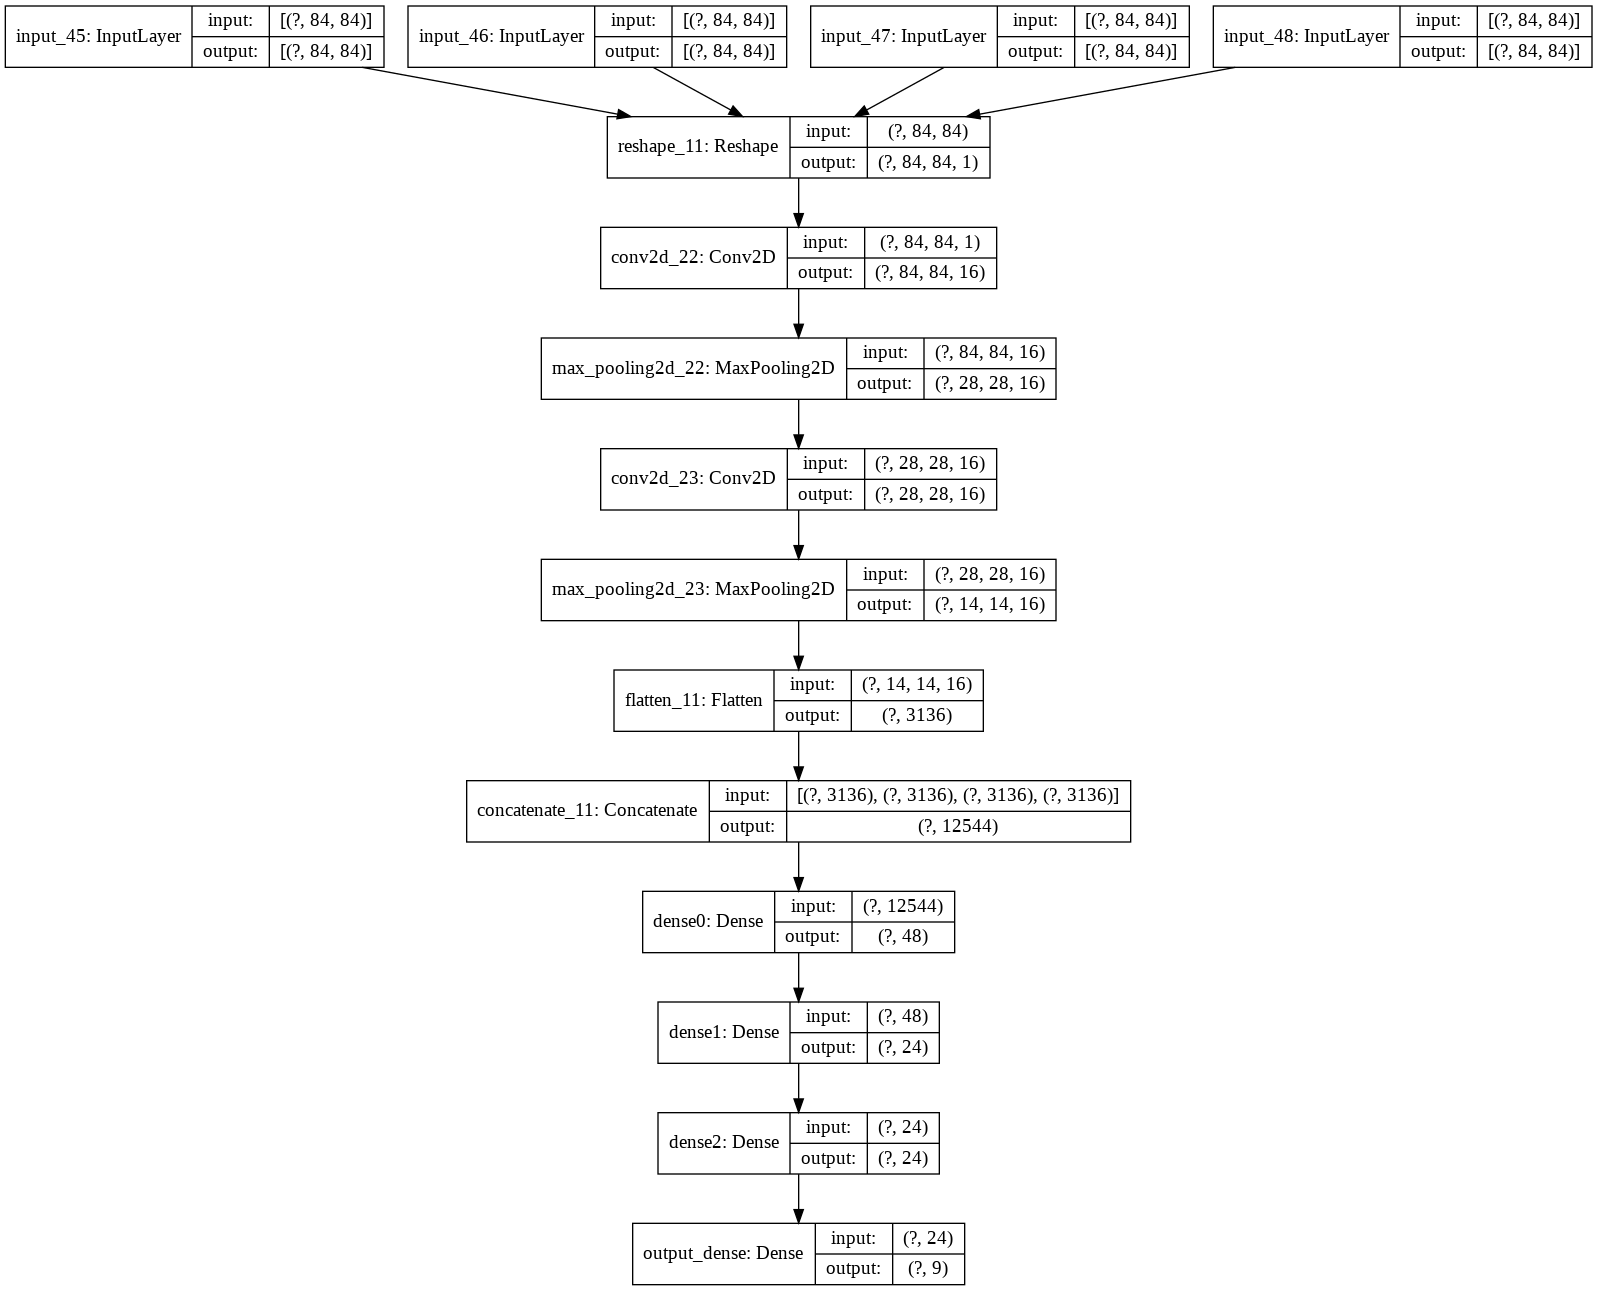

In [50]:
import gym
import tensorflow.keras as keras
from tensorflow.keras import Input
from tensorflow.keras.layers import Concatenate, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Flatten, Reshape
from IPython.display import Image

env = gym.make("MsPacman-v0")
frame_buffer = 4

input_shape = (84, 84)

with tf.device('/device:GPU:0'):
  inputs = []
  for i in range(frame_buffer):
      layer = Input(shape=input_shape)
      inputs.append(layer)

  reshape_layer = Reshape(input_shape + (1,))
  reshaped = [reshape_layer(i) for i in inputs]

  conv_layer = Conv2D(
      filters=16, kernel_size=(3, 3),
      padding='same', activation='relu'
  )
  inputs_convoluted = [conv_layer(inp) for inp in reshaped]

  pool_layer = MaxPooling2D(pool_size=(3, 3))
  inputs_pooled = [pool_layer(i) for i in inputs_convoluted]

  conv_layer2 = Conv2D(
      filters=16, kernel_size=(2, 2),
      padding='same', activation='relu'
  )
  inputs_convoluted = [conv_layer2(i) for i in inputs_pooled]

  pool_layer2 = MaxPooling2D(pool_size=(2, 2))
  inputs_pooled2 = [pool_layer2(i) for i in inputs_convoluted]

  flatten_layer = Flatten()
  flattened = [flatten_layer(i) for i in inputs_pooled2]
  merged = Concatenate()(flattened) if frame_buffer != 1 else flattened[0]

  d0 = Dense(48, activation='relu', name='dense0')(merged)
  d1 = Dense(24, activation='relu', name='dense1')(d0)
  d2 = Dense(24, activation='relu', name='dense2')(d1)

  outputs = \
      Dense(env.action_space.n, activation="relu", name="output_dense")(d2)

  model = keras.Model(
      inputs=inputs,
      outputs=outputs
  )

  model.compile(
      optimizer='Adam',
      loss='mean_squared_error'
  )


keras.utils.plot_model(model, "cnn_model.png", show_shapes=True)
Image("cnn_model.png")

In [ ]:
%matplotlib inline
from sota_dqn import DQNTrainer, BasicReplayMemory
from PIL import Image
import numpy as np
from IPython.display import clear_output

def grayscale(frame):
    img = Image.fromarray(frame).convert('L')
    return np.asarray(img.resize(input_shape))

def cb_clear(_1, _2, _3):
  clear_output(wait=False)

dqn = DQNTrainer(
    env=env,
    model=model,
    observation_preprocessors=[grayscale, ],
    epsilon_decay=0.998,
    input_shape=input_shape,
    memory=BasicReplayMemory(2000),
    frame_buffer_size=frame_buffer,
    episode_callbacks=[cb_clear, track_reward,
                       plot, save_model, append_row, print_table]
)

dqn.train(10, skip=4, max_steps=400)
dqn.train(20, skip=2, max_steps=400)
dqn.train(100, skip=0, max_steps=400)

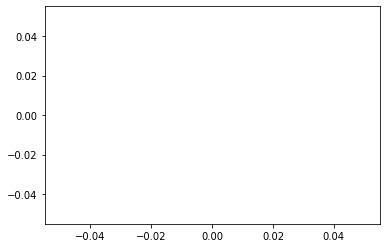

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=range(len(dqn.all_rewards)), y=dqn.all_rewards)
plt.show()

In [ ]:
!zip -r results.zip results
from google.colab import files
files.download("results.zip")

  adding: results/ (stored 0%)
  adding: results/ms-pacman-rewards.png (deflated 8%)
  adding: results/ms-pacman.model/ (stored 0%)
  adding: results/ms-pacman.model/variables/ (stored 0%)
  adding: results/ms-pacman.model/variables/variables.data-00000-of-00001 (deflated 69%)
  adding: results/ms-pacman.model/variables/variables.index (deflated 67%)
  adding: results/ms-pacman.model/saved_model.pb (deflated 91%)
  adding: results/ms-pacman.model/assets/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>